In [ ]:
import os

In [ ]:
# ==========================
# 1️⃣ Mount Google Drive
# ==========================
from google.colab import drive
drive.mount('/content/drive')

# ==========================
# 2️⃣ Define dataset paths
# ==========================
DATASET_PATH = "/content/drive/MyDrive/circor-heart-sound-1.0.3"
TRAIN_CSV = os.path.join(DATASET_PATH, "training_data.csv")
AUDIO_DIR = os.path.join(DATASET_PATH, "training_data")

# ==========================
# 3️⃣ Download if not in Drive
# ==========================
import os

if not os.path.exists(DATASET_PATH):
    print("Dataset not found in Drive. Downloading now...")
    !wget -O circor-heart-sound.zip https://physionet.org/static/published-projects/circor-heart-sound/circor-heart-sound-1.0.3.zip
    # Unzip quietly and overwrite automatically
    !unzip -qo circor-heart-sound.zip -d circor_dataset
    # Copy into Drive
    !cp -r circor_dataset/the-circor-digiscope-phonocardiogram-dataset-1.0.3 "{DATASET_PATH}"
    print("✅ Dataset downloaded & saved to Drive.")
else:
    print("✅ Dataset already exists in Drive. Using Drive copy.")

# ==========================
# 4️⃣ Load CSV
# ==========================
import pandas as pd
df = pd.read_csv(TRAIN_CSV)
print("Dataset loaded. Number of samples:", len(df))
print("Columns:", df.columns)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset already exists in Drive. Using Drive copy.
Dataset loaded. Number of samples: 942
Columns: Index(['Patient ID', 'Recording locations:', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Outcome', 'Campaign', 'Additional ID'],
      dtype='object')


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# -------------------------------
# Audio & preprocessing settings
# -------------------------------
SAMPLE_RATE = 2000   # Hz
DURATION = 5         # seconds
N_MELS = 64
MAX_LEN = SAMPLE_RATE * DURATION  # 5 seconds

# Paths (Drive copy)
DATASET_PATH = "/content/drive/MyDrive/circor-heart-sound-1.0.3"
TRAIN_CSV = os.path.join(DATASET_PATH, "training_data.csv")
AUDIO_DIR = os.path.join(DATASET_PATH, "training_data")

# Load CSV
df = pd.read_csv(TRAIN_CSV)

# -------------------------------
# Filter CSV to only available files
# -------------------------------
available_files = set(os.listdir(AUDIO_DIR))
df = df[df.apply(lambda row: f"{row['Patient ID']}_{row['Recording locations:'].split('+')[0]}.wav" in available_files, axis=1)]
print("Filtered CSV samples available for processing:", len(df))

# -------------------------------
# Preprocessing: audio -> Mel-spectrogram
# -------------------------------
def preprocess_audio(file_path, max_len=MAX_LEN, sr=SAMPLE_RATE, n_mels=N_MELS):
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    # Pad or truncate
    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)))
    # Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# -------------------------------
# SpecAugment-style augmentation for Present class
# -------------------------------
def augment_mel(mel):
    mel_aug = mel.copy()
    # Time masking
    t = np.random.randint(0, mel.shape[1]//4)
    mel_aug[:, t:t+10] = 0
    # Frequency masking
    f = np.random.randint(0, mel.shape[0]//8)
    mel_aug[f:f+5, :] = 0
    # Small noise
    mel_aug += 0.01 * np.random.randn(*mel.shape)
    return mel_aug

# -------------------------------
# Build X, y arrays
# -------------------------------
X = []
y = []

for idx, row in df.iterrows():
    valve = row["Recording locations:"].split('+')[0]
    file_id = f"{row['Patient ID']}_{valve}.wav"
    wav_path = os.path.join(AUDIO_DIR, file_id)

    mel = preprocess_audio(wav_path)
    if mel is None:
        continue

    # Add channel dimension
    X.append(mel[..., np.newaxis])

    # Binary label: 1 = Present, 0 = Absent, ignore Unknown
    if row["Murmur"] == "Present":
        y.append(1)
        # Augment Present class 2x
        for _ in range(2):
            X.append(augment_mel(mel)[..., np.newaxis])
            y.append(1)
    elif row["Murmur"] == "Absent":
        y.append(0)
    else:
        continue

X = np.array(X)
y = np.array(y)

print("Final dataset shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("Present samples:", sum(y==1))
print("Absent samples:", sum(y==0))


Filtered CSV samples available for processing: 562
Final dataset shapes:
X: (794, 64, 20, 1)
y: (758,)
Present samples: 348
Absent samples: 410


Filtered CSV samples available for processing: 562
After rebuild:
X: (526, 64, 20, 1)
y: (526,)
Present: 116
Absent: 410
After SMOTE:
X: (820, 64, 20, 1)
y: (820,)
Present samples: 410
Absent samples: 410


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 20, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 20,    │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 20,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 10,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 10,    │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 10,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 5, 32) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 5, 64) │     18,496 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 5, 64) │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 16, 320)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 16, 128)   │    197,120 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16, 128)   │     16,512 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 16, 128)   │          0 │ bidirectional_1[… │
│ (Multiply)          │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,697 (959.75 KB)

 Trainable params: 245,473 (958.88 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6102 - loss: 0.6864 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7368 - loss: 0.6298 - val_accuracy: 0.5061 - val_loss: 0.7114
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7114 - loss: 0.5962 - val_accuracy: 0.6951 - val_loss: 0.5803
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.7358 - loss: 0.5502 - val_accuracy: 0.6951 - val_loss: 0.5761
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8007 - loss: 0.4849 - val_accuracy: 0.7134 - val_loss: 0.5446
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8669 - loss: 0.3892 - val_accuracy: 0.6646 - val_loss: 0.6586
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.8388 - loss: 0.3761 - val_accuracy: 0.6890 - val_loss: 0.6899
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8903 - loss: 0.3176 - val_accuracy: 0.7317 - 

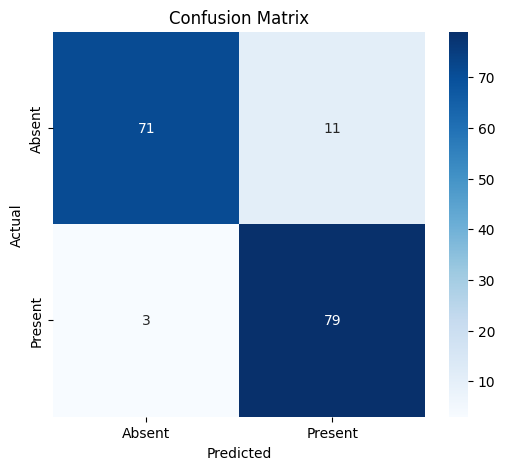

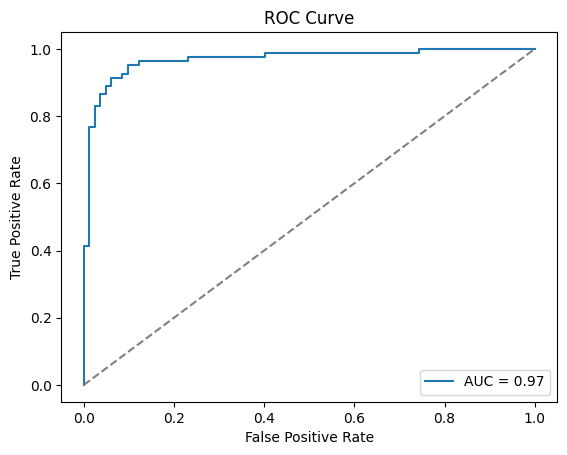

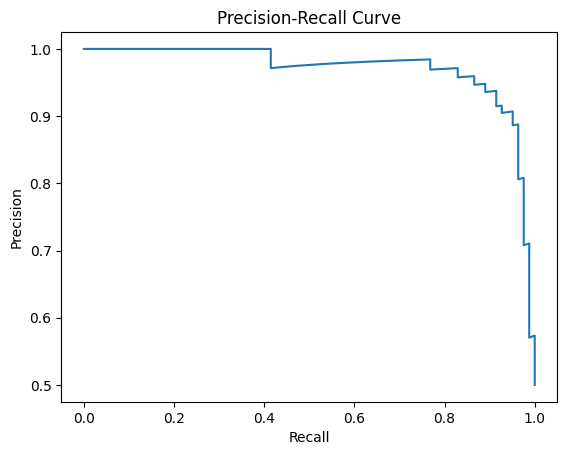

In [ ]:
# ===============================
# Heart Murmur CNN + BiLSTM + Attention with SMOTE
# ===============================

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Audio & preprocessing settings
# -------------------------------
SAMPLE_RATE = 2000   # Hz
DURATION = 5         # seconds
N_MELS = 64
MAX_LEN = SAMPLE_RATE * DURATION  # 5 seconds

# Paths (Drive copy)
DATASET_PATH = "/content/drive/MyDrive/circor-heart-sound-1.0.3"
TRAIN_CSV = os.path.join(DATASET_PATH, "training_data.csv")
AUDIO_DIR = os.path.join(DATASET_PATH, "training_data")

# Load CSV
df = pd.read_csv(TRAIN_CSV)

# -------------------------------
# Filter CSV to only available files
# -------------------------------
available_files = set(os.listdir(AUDIO_DIR))
df = df[df.apply(lambda row: f"{row['Patient ID']}_{row['Recording locations:'].split('+')[0]}.wav" in available_files, axis=1)]
print("Filtered CSV samples available for processing:", len(df))

# -------------------------------
# Preprocessing: audio -> Mel-spectrogram
# -------------------------------
def preprocess_audio(file_path, max_len=MAX_LEN, sr=SAMPLE_RATE, n_mels=N_MELS):
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    # Pad or truncate
    if len(y) > max_len:
        y = y[:max_len]
    else:
        y = np.pad(y, (0, max_len - len(y)))
    # Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# -------------------------------
# Build X, y arrays
# -------------------------------
X = []
y = []

for idx, row in df.iterrows():
    valve = row["Recording locations:"].split('+')[0]
    file_id = f"{row['Patient ID']}_{valve}.wav"
    wav_path = os.path.join(AUDIO_DIR, file_id)

    if not os.path.exists(wav_path):
        continue  # skip missing files

    mel = preprocess_audio(wav_path)
    if mel is None:
        continue  # skip failed load

    # Only consider known labels
    if row["Murmur"] == "Present":
        label = 1
    elif row["Murmur"] == "Absent":
        label = 0
    else:
        continue  # skip Unknown

    X.append(mel[..., np.newaxis])
    y.append(label)

X = np.array(X)
y = np.array(y)

print("After rebuild:")
print("X:", X.shape)
print("y:", y.shape)
print("Present:", sum(y==1))
print("Absent:", sum(y==0))


# -------------------------------
# Apply SMOTE to balance classes
# -------------------------------
nsamples, n_mels, time, channels = X.shape
X_flat = X.reshape((nsamples, n_mels*time))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_flat, y)

X_res = X_res.reshape((-1, n_mels, time, channels))


print("After SMOTE:")
print("X:", X_res.shape)
print("y:", y_res.shape)
print("Present samples:", sum(y_res==1))
print("Absent samples:", sum(y_res==0))

# -------------------------------
# Train-test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# -------------------------------
# Attention block
# -------------------------------
def attention_block(inputs):
    a = layers.Dense(inputs.shape[-1], activation="softmax")(inputs)
    output = layers.Multiply()([inputs, a])
    return output

# -------------------------------
# Model definition
# -------------------------------
input_shape = X_train.shape[1:]
inputs = layers.Input(shape=input_shape)

# CNN backbone
x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# Reshape for LSTM: (batch, time, features)
shape = x.shape
x = layers.Reshape((shape[1], shape[2]*shape[3]))(x)

# BiLSTM
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

# Attention
x = attention_block(x)
x = layers.GlobalAveragePooling1D()(x)

# Dense layers
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# -------------------------------
# Training
# -------------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# -------------------------------
# Evaluation
# -------------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Absent","Present"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Absent","Present"], yticklabels=["Absent","Present"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
True Label: Absent
Predicted Label: Absent
Probability: 0.02


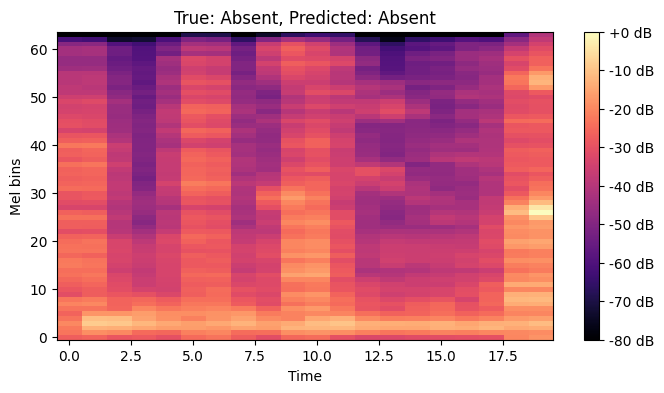

In [ ]:
import random

# Pick a random index
idx = random.randint(0, len(X)-1)

# Get the Mel-spectrogram
X_sample = X[idx][np.newaxis, ...]  # add batch dimension
true_label = "Present" if y[idx]==1 else "Absent"

# Predict
pred_prob = model.predict(X_sample)[0][0]
pred_label = "Present" if pred_prob > 0.5 else "Absent"

print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Probability: {pred_prob:.2f}")

# Optional: visualize Mel-spectrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.imshow(X[idx].squeeze(), aspect='auto', origin='lower', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"True: {true_label}, Predicted: {pred_label}")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.show()


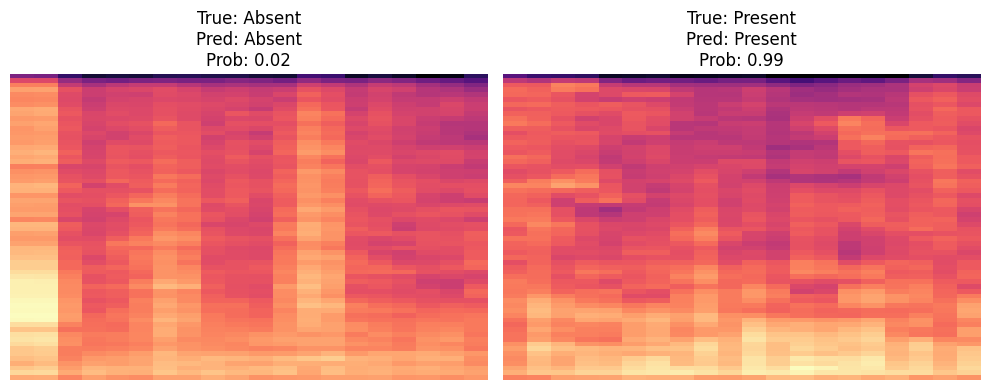

In [ ]:
# Get indices for each class
absent_indices = [i for i, label in enumerate(y) if label == 0]
present_indices = [i for i, label in enumerate(y) if label == 1]

# Pick one random from each class
idx_absent = random.choice(absent_indices)
idx_present = random.choice(present_indices)

demo_indices = [idx_absent, idx_present]

plt.figure(figsize=(10, 4))
for i, idx in enumerate(demo_indices):
    X_sample = X[idx][np.newaxis, ...]
    true_label = "Present" if y[idx] == 1 else "Absent"
    pred_prob = model.predict(X_sample, verbose=0)[0][0]
    pred_label = "Present" if pred_prob > 0.5 else "Absent"

    plt.subplot(1, 2, i+1)
    plt.imshow(X[idx].squeeze(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()
